In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# Define bucket
g = 9.807         #[m/s^2]
bucket_area = 1   #[m^2]
spigot_area = 0.1 #[m^2]
h_max = 10        #[m]
h_spigot = 3      #[m]
time_step = 1     #[s]

In [3]:
# Generate some synthetic "precipitation" as input
in_list = [0]
for i in range(1,10000):
    if random.random() < 0.2:
        in_list.append(0)
    else:
        if in_list[i-1] < 1:
            if random.random() < 0.6:
                in_list.append(random.uniform(0,1))
            else:
                in_list.append(random.uniform(0,8))
        else:
            if random.random() < 0.3:
                in_list.append(random.uniform(0,1))
            else:
                in_list.append(random.uniform(0,5))

In [4]:
# Bucket model

# Memory to store model results
df = pd.DataFrame(index=list(range(len(in_list))),columns=['input', 'et', 'h_water_level', 'mass_overflow', 'spigot_out'])

# Initial conditions
h_water_level = 0
mass_overflow = 0

# Main loop through time
for t, mass_in in enumerate(in_list):
    
    # Add the input mass to the bucket
    h_water_level = h_water_level + mass_in
    
    # Lose mass out of the bucket. Some periodic type loss, evaporation, and some infiltration...
    et = np.max([0, np.sin(t) * random.uniform(0.5,0.6)])
    h_water_level = np.max([0 , h_water_level - et])
    h_water_level = np.max([0 , h_water_level * random.uniform(0.8,0.9)])
        
    # Overflow if the bucket is too full
    if h_water_level > h_max:
        mass_overflow = h_water_level - h_max
        h_water_level = h_max
    
    # Calculate head on the spigot
    h_head_over_spigot = h_water_level - h_spigot
    
    # Calculate water leaving bucket through spigot
    if h_head_over_spigot > 0:
        velocity_out = np.sqrt(2 * g * h_head_over_spigot)
        spigot_out = velocity_out *  spigot_area * time_step
        h_water_level = h_water_level - spigot_out
    else:
        spigot_out = 0
        
    # Save the data in time series    
    df.loc[t,'input'] = mass_in
    df.loc[t,'et'] = et
    df.loc[t,'h_water_level'] = h_water_level
    df.loc[t,'mass_overflow'] = mass_overflow
    df.loc[t,'spigot_out'] = spigot_out
    
    mass_overflow = 0

In [5]:
# Check to make sure that the is mass going over the top of the bucket
print("overflow mean", np.round(df.mass_overflow.mean(),4))
print("overflow max", np.round(df.mass_overflow.max(),4))

overflow mean 0.0177
overflow max 2.9557


<AxesSubplot:>

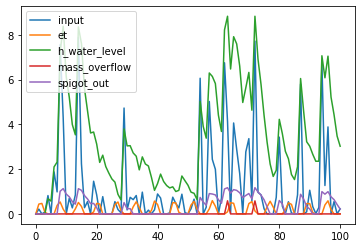

In [6]:
df.loc[:100,:].plot()

In [7]:
df.head()

,input,et,h_water_level,mass_overflow,spigot_out
0,0,0.0,0.0,0,0
1,0.215224,0.439798,0.0,0,0
2,0,0.468422,0.0,0,0
3,0.084287,0.071521,0.010382,0,0
4,0.819476,0.0,0.676062,0,0


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable 
import sklearn
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange, tqdm

In [9]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, batch_size, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True) #lstm
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc_1 =  nn.Linear(hidden_size, num_classes) #fully connected 1
   
    def forward(self, x, init_states=None):

        if init_states is None:
            h_t = Variable(torch.zeros(batch_size, self.hidden_size)) #hidden state
            c_t = Variable(torch.zeros(batch_size, self.hidden_size)) #internal state
        else:
            h_t, c_t = init_states
           
        out, _ = self.lstm(x)
        out = self.relu(out)
        prediction = self.fc_1(out) # Dense, fully connected layer
        
        return prediction

In [10]:
def check_validation_period(n_plot=100):
    lstm_output_val = lstm(torch.Tensor(np_val_seq_X))
    val_spigot_prediction = []
    val_overflow_prediction = []
    for i in range(lstm_output_val.shape[0]):
        val_spigot_prediction.append((lstm_output_val[i,-1,1].cpu().detach().numpy() * \
                                np.std(df.iloc[train_start:train_end,4])) + \
                               np.mean(df.iloc[train_start:train_end,4]))
        
        val_overflow_prediction.append((lstm_output_val[i,-1,0].cpu().detach().numpy() * \
                                np.std(df.iloc[train_start:train_end,3])) + \
                               np.mean(df.iloc[train_start:train_end,3]))
        
    spigot_out = df.loc[val_start:val_end, 'spigot_out']
    spigot_mean = np.mean(spigot_out)
    spigot_pred_variance = 0
    spigot_obs_variance = 0

    overflow_out = df.loc[val_start:val_end, 'mass_overflow']
    overflow_mean = np.mean(overflow_out)
    overflow_pred_variance = 0
    overflow_obs_variance = 0

    for i, pred_spigot in enumerate(val_spigot_prediction):
        t = i + seq_length - 1
        spigot_pred_variance += np.power(( pred_spigot          - spigot_out.values[t]), 2)
        spigot_obs_variance  += np.power(( spigot_mean          - spigot_out.values[t]), 2)

    for i, pred_overflow in enumerate(val_overflow_prediction):
        t = i + seq_length - 1
        overflow_pred_variance += np.power((pred_overflow          - overflow_out.values[t]), 2)
        overflow_obs_variance  += np.power((overflow_mean          - overflow_out.values[t]), 2)
        
    print("Spigot NSE",   np.round( 1 - ( spigot_pred_variance   / spigot_obs_variance   ), 4))
    print("Overflow NSE", np.round( 1 - ( overflow_pred_variance / overflow_obs_variance ), 4))
    
    plt.plot(df.loc[val_start+seq_length-1:val_start+n_plot+seq_length-1,'spigot_out'].values, label="Spigot out")
    plt.plot(val_spigot_prediction[:n_plot], label="LSTM spigot")
    plt.legend()
    plt.show()
    plt.close()
    plt.plot(df.loc[val_start+seq_length-1:val_start+n_plot+seq_length-1,'mass_overflow'].values, label="Overflow")
    plt.plot(val_overflow_prediction[:n_plot], label="LSTM mass_overflow")
    plt.legend()
    plt.show()
    plt.close()
#check_validation_period()

In [17]:
device='cpu'
n_input=1
n_output=2
hidden_state_size = 32 #32
num_layers= 8          #6
num_epochs = 25        #25
batch_size = 256       #256
seq_length= 124        #240
learning_rate = np.linspace(start=0.1, stop=0.00001, num=num_epochs)     # start=0.1, stop=0.00001

torch.manual_seed(1)

lstm = LSTM1(num_classes=n_output,  input_size=n_input,    hidden_size=hidden_state_size, 
             num_layers=num_layers, batch_size=batch_size, seq_length=seq_length)


In [18]:
train_start = 0
train_end = 6000
val_start = 7000
val_end = 8000
test_start = 8000
test_end = 9990

scaler = StandardScaler()

scaler_train = scaler.fit_transform(df.iloc[train_start:train_end,:])
scaler_test = scaler.transform(df.iloc[test_start:test_end,:])
scaler_val = scaler.transform(df.iloc[val_start:val_end,:])

np_train_seq_X = np.zeros((scaler_train.shape[0] - seq_length, seq_length, n_input))
np_train_seq_y = np.zeros((scaler_train.shape[0] - seq_length, seq_length, n_output))
for i in range(0, scaler_train.shape[0] - seq_length):
    t = i+seq_length
    np_train_seq_X[i, :, :] = scaler_train[i:t,:n_input]
    np_train_seq_y[i, :, :] = scaler_train[i:t,3:]

np_val_seq_X = np.zeros((scaler_val.shape[0] - seq_length, seq_length, n_input))
np_val_seq_y = np.zeros((scaler_val.shape[0] - seq_length, seq_length, n_output))
for i in range(0, scaler_val.shape[0] - seq_length):
    t = i+seq_length
    np_val_seq_X[i, :, :] = scaler_val[i:t,:n_input]
    np_val_seq_y[i, :, :] = scaler_val[t,3:]
    
np_test_seq_X = np.zeros((scaler_test.shape[0] - seq_length, seq_length, n_input))
np_test_seq_y = np.zeros((scaler_test.shape[0] - seq_length, seq_length, n_output))
for i in range(0, scaler_test.shape[0] - seq_length):
    t = i+seq_length
    np_test_seq_X[i, :, :] = scaler_test[i:t,:n_input]
    np_test_seq_y[i, :, :] = scaler_test[i:t,3:]

ds_train = torch.utils.data.TensorDataset(torch.Tensor(np_train_seq_X), torch.Tensor(np_train_seq_y))
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
ds_test = torch.utils.data.TensorDataset(torch.Tensor(np_test_seq_X), torch.Tensor(np_test_seq_y))
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=True)
ds_val = torch.utils.data.TensorDataset(torch.Tensor(np_val_seq_X), torch.Tensor(np_val_seq_y))
val_loader = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=True)

In [22]:
criterion = nn.MSELoss()  # Use costome loss function. 
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])
epoch_bar = tqdm(range(num_epochs),desc="Training", position=0, total=num_epochs)

for epoch in epoch_bar:
    batch_bar = tqdm(enumerate(train_loader),
                     desc="Epoch: {}".format(str(epoch)),
                     position=1,
                     total=len(train_loader))

    for i, (data, targets) in batch_bar:
        
        optimizer.zero_grad()
        
        optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[i])

        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward
        lstm_output = lstm(data) 
        loss = criterion(lstm_output,targets)

        #backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        batch_bar.set_postfix(loss=loss.cpu().item(),
                              RMSE="{:.2f}".format(loss**(1/2)),
                              epoch=epoch)
        batch_bar.update()

    with torch.no_grad():
        rmse_list = []
        for i, (data_, targets_) in enumerate(val_loader):
            data_ = data_.to(device=device)
            targets_ = targets_.to(device=device)
            lstm_output_ = lstm(data_)
            MSE_ = criterion(lstm_output_, targets_)
            rmse_list.append(MSE_**(1/2))
            
    epoch_bar.set_postfix(loss=loss.cpu().item(),
                          RMSE="{:.2f}".format(np.mean(np.array(rmse_list))),
                          epoch=epoch)
    batch_bar.update()
    


Spigot NSE 0.9439
Overflow NSE 0.6906


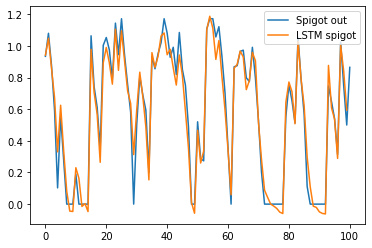

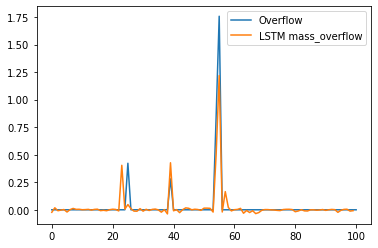

In [21]:
check_validation_period()

In [15]:
# With noize:
    # Spigot NSE 0.9525
    # Overflow NSE 0.5488
    
# Without noise
    # Spigot NSE 0.9767
    # Overflow NSE 0.9798